In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from torch.utils.data import  DataLoader
from handover_grasping.model import HANet
from handover_grasping.Datavisualizer import handover_grasping_dataset
from handover_grasping.utils import get_grasp_line, get_affordancemap

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Dataloader for testing set

In [5]:
DATA_PATH = '/home/arg/handover_grasping/HANet_sample_datasets'

dataset = handover_grasping_dataset(DATA_PATH, mode='test', color_type='png')
dataloader = DataLoader(dataset, batch_size = 1, shuffle = False, num_workers = 8)

Initial HANet and load weight

In [3]:
net = HANet(pretrained=True,n_class=4)
net = net.cuda()
net.eval()

Load pretrained complete


HANet(
  (net): FCN_model(
    (color_trunk): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=

Inference

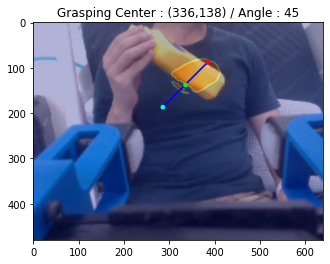

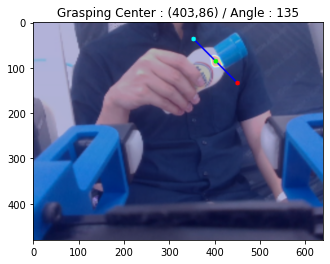

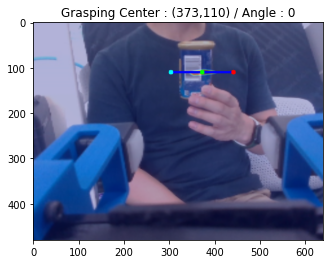

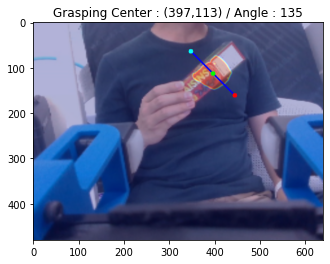

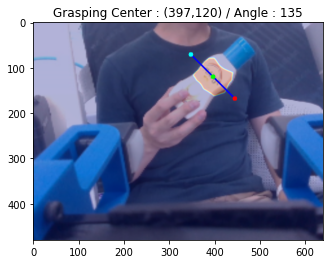

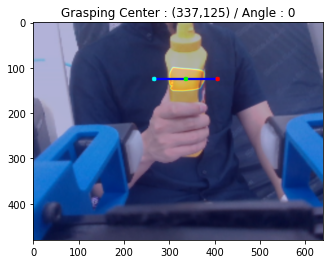

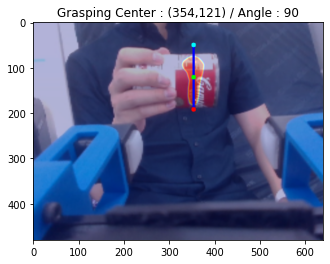

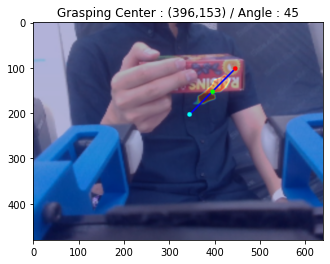

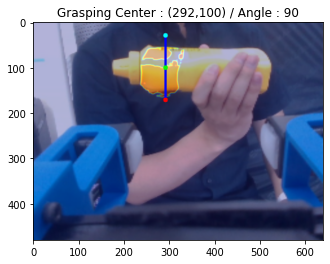

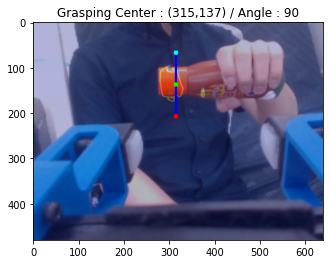

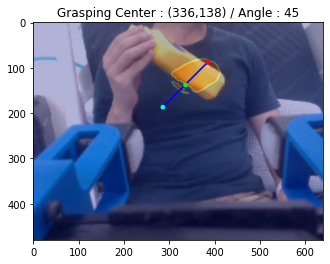

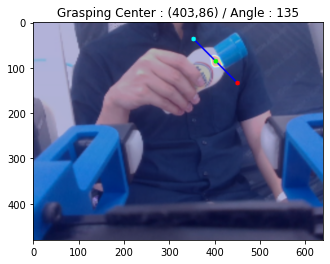

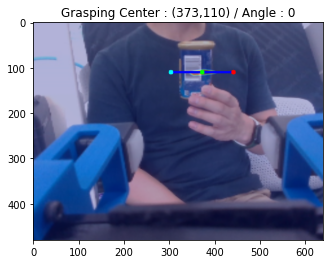

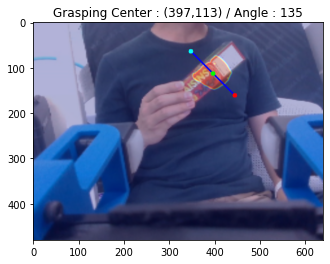

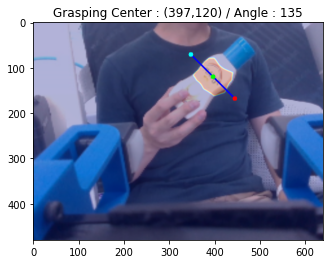

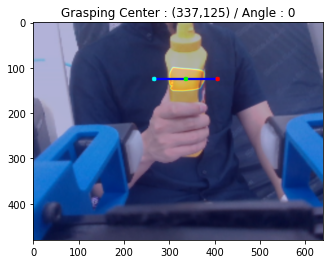

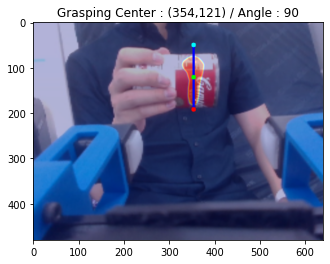

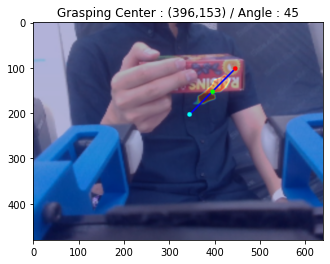

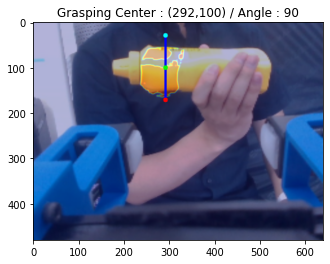

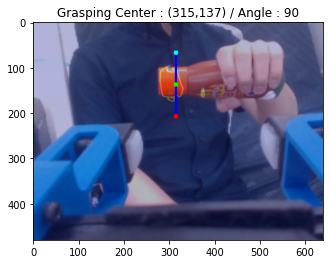

In [8]:
for i, batch in enumerate(dataloader):
    color = batch['color'].cuda()
    depth = batch['depth'].cuda()

    predict = net(color, depth)
    predict = predict.cpu().detach().numpy()

    depth_origin = batch['depth_origin'].cpu().detach().numpy()[0]
    color_origin = batch['color_origin'].cpu().detach().numpy()[0]

    affordanceMap, x, y, theta = get_affordancemap(predict, depth_origin)

    Combine = cv2.addWeighted(color_origin,0.7,affordanceMap, 0.3,0)
    Result = cv2.resize(Combine, (640,480))
    Result = cv2.circle(Result, (int(x), int(y)), 5, (0,255,0), -1)

    point1, point2 = get_grasp_line(theta, [y, x], depth_origin)

    Result = cv2.line(Result,point1,point2,(0,0,255),3)
    Result = cv2.circle(Result, (int(x), int(y)), 5, (0,255,0), -1)
    Result = cv2.circle(Result, point1, 5, (255,0,0), -1)
    Result = cv2.circle(Result, point2, 5, (0,255,255), -1)

    plt.imshow(Result)
    plt.title("Grasping Center : ({},{}) / Angle : {}".format(x, y, theta))
    plt.show()